In [101]:
import sklearn
import numpy as np
from numpy import ma
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy.random as r

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

In [118]:
names =['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = pd.read_csv('train.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")

names_test =['id', 'comment_text']
df_test = pd.read_csv('test.csv',header=None,sep=",",names=names_test, encoding = "ISO-8859-1")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [119]:
df['toxic_score'] = df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#drop unnecessary columns
df = df.drop(['id', 'toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate'], axis=1)
#drop first row
df.drop(df.index[:1], inplace=True)

df_test = df_test.drop(['id'], axis=1)
df_test.drop(df_test.index[:1], inplace=True)
#df.drop(df.index[:150000], inplace=True) #smaller data set

In [120]:
# print(df)

In [121]:
df.head(5)
df_test.head(5)

,comment_text
1,Yo bitch Ja Rule is more succesful then you'll...
2,== From RfC == \n\n The title is fine as it is...
3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
4,":If you have a look back at the source, the in..."
5,I don't anonymously edit articles at all.


In [122]:
bad_words = []
negative_file = open("negative-words.txt", "r")
for line in negative_file:
    bad_words.append(line.strip("\n"))
negative_file.close()
profanity_file = open("profanity-words.txt", "r")
for line in profanity_file:
    if (line.strip("\n") not in bad_words):
        bad_words.append(line.strip("\n"))
profanity_file.close()
# print(bad_words)

In [123]:
data = df.values
data_test = df_test.values

X = data[:,0].reshape((159571,1))
Y = data[:,1].reshape((159571,1))

toxic_count = 0
not_toxic_count = 0
validation_count = 0

X_tr = []
Y_tr = []
X_test = []
X_val = []
Y_val = []

for index in range(0,159571):
    if (int(Y[index][0]) == 1 and toxic_count < 7500) or (int(Y[index][0]) == 0 and not_toxic_count < 7500):
        Y_tr.append(int(Y[index][0]))
        X_tr.append(X[index][0])
        if (int(Y[index][0]) == 1):
            toxic_count += 1
        else:
            not_toxic_count += 1
    if toxic_count == 7500 and not_toxic_count == 7500:
        Y_val.append(int(Y[index][0]))
        X_val.append(X[index][0])
        validation_count += 1
    if validation_count == 15000:
        break

# X_tr = np.array(X_tr).reshape((15000, 1))
Y_tr = np.array(Y_tr).reshape((15000, 1))
Y_val = np.array(Y_val).reshape((15000, 1))

for index in range(0, 15000):
    X_test.append(data_test[index][0])

cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_tr_features = cv.fit_transform(X_tr).toarray()
X_test_features = cv.fit_transform(X_test).toarray()
X_val_features = cv.fit_transform(X_val).toarray()

# Logistic Regression

In [58]:
# Scaling 
# X_tr_scale = preprocessing.scale(X_tr_features)
X_tr_scale = X_tr_features
# X_tr_scale = preprocessing.scale(X_tr_scale)

In [10]:
# Sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [11]:
# Append a column of ones in the beginning of x_train an save in variable a.
ones = np.ones(X_tr_scale.shape[0]).reshape((X_tr_scale.shape[0], 1))
a = np.hstack((ones, X_tr_scale))
print(a)

[[1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 ...
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
 [1.e+00 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]]


In [12]:
w = np.zeros((a.shape[1], 1))
print(w.shape)

(5214, 1)


In [13]:
def hypothesis(a , w):
    return sigmoid(np.dot(a, w))

In [14]:
yhat = hypothesis(a, w)
print(yhat)

[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]


In [15]:
def likelihood(X_tr , Y_tr , w , n):
    yhat = hypothesis(X_tr, w)
    Y_tr = Y_tr.reshape((yhat.shape[0], 1))
    likelihood = np.sum(Y_tr * ma.log(yhat) + (1 - Y_tr) * ma.log(1 - yhat))
    return likelihood

print(likelihood(a, Y_tr, w, a.shape[0]))

-10397.207708399179


In [16]:
# TODO - Write the gradient ascent function - 25 points
def Gradient_Ascent(a, y, learning_rate, num_iters):
    n = a.shape[0] # Number of training examples.
    # TODO - Initialize w. Zeros vector of shape x_train.shape[1],1
    w = np.zeros((a.shape[1], 1))
    # TODO - Reshape y to be a rank 2 matrix.
    y = y.reshape((y.shape[0], 1))
    # TODO - Initiating list to store values of likelihood after few iterations.
    likelihood_values = []
    for i in range(num_iters):
        yhat = hypothesis(a, w)
        error = y - yhat
        gradient = np.dot(a.T, error)
        # Updating Parameters
        w = w + (learning_rate / n) * gradient
        if (i % 100) == 0:
            print(i)
            likelihood_values.append(likelihood(a,y,w,n))
        
    return w, likelihood_values

learning_rate = 0.1
num_iters = 50000
w, likelihood_values = Gradient_Ascent(a, Y_tr, learning_rate, num_iters)
print(w)

0
100
200
300
400
500
600
700
800


KeyboardInterrupt: 

In [ ]:
# Run this cell to plot Likelihood v/s Number of Iterations.
iters = np.array(range(0,num_iters,100))
plt.plot(iters,likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Likelihood')
plt.title("Likelihood vs Number of Iterations.")
plt.grid()
print(likelihood_values[-1])

In [59]:
logreg = LogisticRegression(C=100000000)
logreg.fit(X_tr_scale, Y_tr.ravel())
# TODO - Find the predicted values on training set using logreg.predict - 5 points
yhat = logreg.predict(X_tr_scale)
# TODO - Find the accuracy achieved on training set using logreg.score - 5 points
acc = logreg.score(X_tr_scale, Y_tr.ravel())

print("Accuracy on training data = %f" % acc)

w = logreg.coef_
intercept = logreg.intercept_
# VERIFY - Compare the parameters computed by logreg model and gradient ascent. They should be nearly same.
print(w)
print(intercept)

acc_val = logreg.score(X_val_features, Y_val.ravel())
print("Accuracy on validation data = %f" % acc_val)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy on training data = 0.902667
[[0.         0.         1.996149   ... 0.637581   0.         0.93918193]]
[-1.37313343]
Accuracy on validation data = 0.911600


# Neural Networks 

In [102]:
names =['id', 'comment_text']
df = pd.read_csv('test.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")
df = df.drop(['id'], axis=1)
df.drop(df.index[:150000], inplace=True)

X_test = df['comment_text']
Y_test = np.zeros((df.shape[0], 1))
    
cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_test_features = cv.fit_transform(X_test).toarray()

X_scale = StandardScaler()
X_tr = X_scale.fit_transform(X_tr_features)
X_test = X_scale.fit_transform(X_test_features)
print(X_tr)
print(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[[ 0.          0.         -0.01414355 ... -0.0258285   0.
  -0.01633211]
 [ 0.          0.         -0.01414355 ... -0.0258285   0.
  -0.01633211]
 [ 0.          0.         -0.01414355 ... -0.0258285   0.
  -0.01633211]
 ...
 [ 0.          0.         -0.01414355 ... -0.0258285   0.
  -0.01633211]
 [ 0.          0.         -0.01414355 ... -0.0258285   0.
  -0.01633211]
 [ 0.          0.         -0.01414355 ... -0.0258285   0.
  -0.01633211]]
[[ 0.          0.         -0.01777795 ...  0.          0.
  -0.01777795]
 [ 0.          0.         -0.01777795 ...  0.          0.
  -0.01777795]
 [ 0.          0.         -0.01777795 ...  0.          0.
  -0.01777795]
 ...
 [ 0.          0.         -0.01777795 ...  0.          0.
  -0.01777795]
 [ 0.          0.         -0.01777795 ...  0.          0.
  -0.01777795]
 [ 0.          0.         -0.01777795 ...  0.          0.
  -0.01777795]]


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [103]:
"""
#Setting up the output layer
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
"""

'\n#Setting up the output layer\ndef convert_y_to_vect(y):\n    y_vect = np.zeros((len(y), 10))\n    for i in range(len(y)):\n        y_vect[i, y[i]] = 1\n    return y_vect\n'

In [104]:
"""
#Converting the training and test targets to vectors
y_v_train = convert_y_to_vect(Y_tr)
y_v_test = convert_y_to_vect(Y_test)
"""

'\n#Converting the training and test targets to vectors\ny_v_train = convert_y_to_vect(Y_tr)\ny_v_test = convert_y_to_vect(Y_test)\n'

In [105]:
"""
#A quick check to see that our code performs as we expect 
print(y_train[0:4])
print(y_v_train[0:4])
"""

'\n#A quick check to see that our code performs as we expect \nprint(y_train[0:4])\nprint(y_v_train[0:4])\n'

In [106]:
#create neural network

In [107]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

In [108]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [109]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [110]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [111]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [114]:
#The Back Propagation Algorithm
def train_nn(nn_structure, X, y, iter_num=10, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%10 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [115]:
#run neural network

In [116]:
num_features = len(bad_words)
nn_structure = [num_features, 30, 1]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_tr, Y_tr, 100)

Starting gradient descent for 100 iterations
Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100


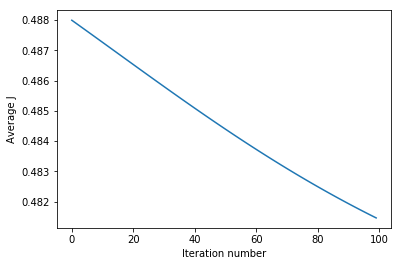

In [117]:
#learning curve
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [124]:
# get the prediction accuracy and print
X_test = X_scale.fit_transform(X_val_features)
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(Y_val, y_pred) * 100))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'accuracy_score' is not defined